In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

In [ ]:
Prepare Data

In [2]:
from sklearn import preprocessing
dataset_orig = pd.read_csv('../../../data/h181.csv')

# ## Drop NULL values
dataset_orig = dataset_orig.dropna()


dataset_orig = dataset_orig.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})


dataset_orig = dataset_orig[dataset_orig['PANEL'] == 20]
dataset_orig = dataset_orig[dataset_orig['REGION'] >= 0] # remove values -1
dataset_orig = dataset_orig[dataset_orig['AGE'] >= 0] # remove values -1
dataset_orig = dataset_orig[dataset_orig['MARRY'] >= 0] # remove values -1, -7, -8, -9
dataset_orig = dataset_orig[dataset_orig['ASTHDX'] >= 0] # remove values -1, -7, -8, -9
dataset_orig = dataset_orig[(dataset_orig[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]

# ## Change symbolics to numerics
dataset_orig['RACEV2X'] = np.where((dataset_orig['HISPANX'] == 2 ) & (dataset_orig['RACEV2X'] == 1), 1, dataset_orig['RACEV2X'])
dataset_orig['RACEV2X'] = np.where(dataset_orig['RACEV2X'] != 1 , 0, dataset_orig['RACEV2X'])
dataset_orig = dataset_orig.rename(columns={"RACEV2X" : "RACE"})
# dataset_orig['UTILIZATION'] = np.where(dataset_orig['UTILIZATION'] >= 10, 1, 0)



def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

dataset_orig['TOTEXP15'] = dataset_orig.apply(lambda row: utilization(row), axis=1)
lessE = dataset_orig['TOTEXP15'] < 10.0
dataset_orig.loc[lessE,'TOTEXP15'] = 0.0
moreE = dataset_orig['TOTEXP15'] >= 10.0
dataset_orig.loc[moreE,'TOTEXP15'] = 1.0

dataset_orig = dataset_orig.rename(columns = {'TOTEXP15' : 'UTILIZATION'})

dataset_orig = dataset_orig[['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']]

dataset_orig = dataset_orig.rename(columns={"UTILIZATION": "Probability","RACE" : "race"})
protected_attribute = 'race'


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)

dataset_orig_male , dataset_orig_female = [x for _, x in dataset_orig.groupby(dataset_orig[protected_attribute] == 0)]

(dataset_orig.head(5))

,REGION,AGE,SEX,race,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,PERWT15F,Probability
0,0.333333,0.623529,0.0,1.0,0.444444,0.0,0.333333,0.333333,0.833333,0.666667,...,1.0,0.430862,0.813087,0.363636,0.142857,1.0,0.00,0.5,0.231848,1.0
1,0.333333,0.658824,1.0,1.0,0.222222,0.0,0.333333,0.333333,0.833333,0.666667,...,1.0,0.362896,0.428658,0.787879,1.000000,1.0,0.50,0.5,0.192752,1.0
2,0.333333,0.270588,1.0,1.0,0.444444,1.0,0.333333,0.333333,0.333333,0.333333,...,1.0,0.766251,0.714992,0.484848,0.142857,0.4,0.25,0.5,0.182379,0.0
3,0.333333,0.035294,0.0,1.0,0.555556,0.0,0.666667,0.666667,0.333333,0.666667,...,0.0,0.098680,0.096409,0.242424,0.000000,0.0,0.25,0.5,0.214944,0.0
4,0.666667,0.317647,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.500000,0.333333,...,0.0,0.098680,0.096409,0.242424,0.000000,0.4,0.50,0.0,0.000000,0.0


# Fairway¶ 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy
protected_attribute = 'race'

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2)
X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']

clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)


dataset_orig_male , dataset_orig_female = [x for _, x in dataset_orig_train.groupby(dataset_orig_train[protected_attribute] == 0)]
dataset_orig_male[protected_attribute] = 0
X_train_male, y_train_male = dataset_orig_male.loc[:, dataset_orig_male.columns != 'Probability'], dataset_orig_male['Probability']
clf_male = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_male.fit(X_train_male, y_train_male)
X_train_female, y_train_female = dataset_orig_female.loc[:, dataset_orig_female.columns != 'Probability'], dataset_orig_female['Probability']
clf_female = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_female.fit(X_train_female, y_train_female)

for index,row in dataset_orig_train.iterrows():
    row_ = [row.values[0:len(row.values)-1]]
    y_male = clf_male.predict(row_)
    y_female = clf_female.predict(row_)
    if y_male[0] != y_female[0]:        
        dataset_orig_train = dataset_orig_train.drop(index)

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

aod :race 0.02
eod :race 0.04
SPD: 0.03
DI: 0.4
aod :race 0.01
eod :race 0.02
SPD: 0.03
DI: 0.34


# Graph

In [12]:
causal_graph = """
digraph {
SEX;
race;
REGION;
ACTDTY;
MCS42
Probability;
U[label="Unobserved Confounders"];

SEX -> Probability;
race -> Probability;
race -> REGION; REGION -> Probability;
race -> ACTDTY; ACTDTY -> Probability;
race -> MCS42; MCS42 -> Probability;
U->race;U->Probability;
}
"""

## dowhy works for binary inputs only


dataset_orig['Probability'] = np.where(dataset_orig['Probability'] == 0, False, True)
dataset_orig[protected_attribute] = np.where(dataset_orig[protected_attribute] == 1, True, False)

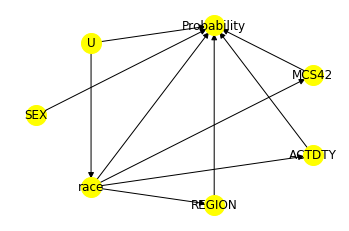

In [13]:
# With graph
model=CausalModel(
        data = dataset_orig,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [14]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                 
───────(Expectation(Probability|SEX))
d[race]                              
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,SEX,U) = P(Probability|race,SEX)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [15]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                 
───────(Expectation(Probability|SEX))
d[race]                              
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,SEX,U) = P(Probability|race,SEX)

## Realized estimand
b: Probability~race+SEX
Target units: ate

## Estimate
Mean value: 0.04303637831976281

Causal Estimate is 0.04303637831976281


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [18]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.04303637831976281
New effect:0.04268706437309202



# Replace Treatment with Placebo

In [17]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.041134179065779604
New effect:0.0004757464818184276
p value:0.5



# Remove Random Subset of Data

In [18]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.041134179065779604
New effect:0.04177107362160824
p value:0.41

